In [107]:
import os
import json
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch,FancyArrowPatch
pplt.rc['reso']='xx-hi'
pplt.rc['figure.dpi'] = 300
warnings.filterwarnings('ignore')

In [221]:
FILEDIR    = '/global/cfs/cdirs/m4334/sferrett/monsoon-sr/data/interim'
SPLITDIR   = '/global/cfs/cdirs/m4334/sferrett/monsoon-sr/data/splits'
MODELDIR   = '/global/cfs/cdirs/m4334/sferrett/monsoon-sr/models'
RESULTSDIR = '/global/cfs/cdirs/m4334/sferrett/monsoon-sr/data/results'
PRTHRESH   = 0.1
LANDTHRESH = 0.5
GREEN      = 'jungle green'
BLUE       = '#4472C4'
YELLOW     = 'sea blue'

In [206]:
globalmin = 0
globalmax = 120
binedges  = np.linspace(globalmin,globalmax,60)
landfrac  = xr.open_dataarray(f'{FILEDIR}/lf.nc')

### Precipitation Distributions

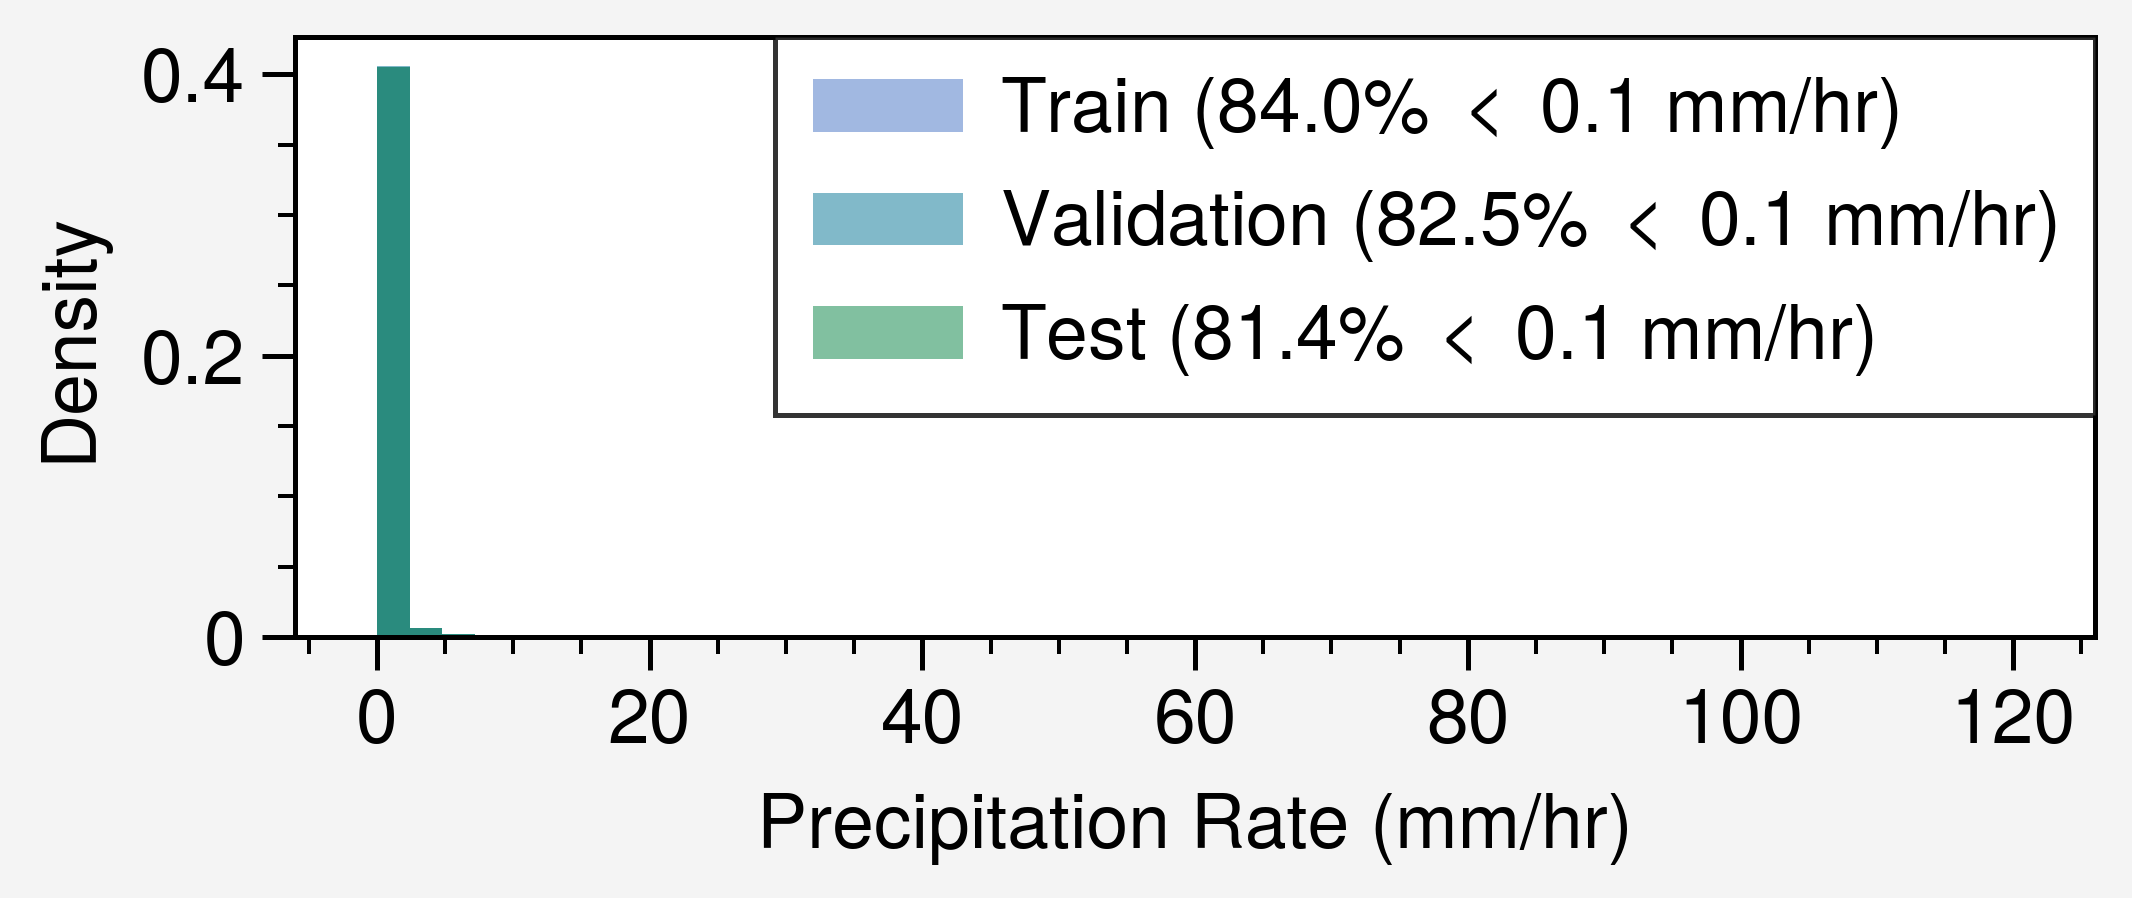

In [283]:
splits = {
    'Train':(xr.open_dataset(f'{SPLITDIR}/train.h5',engine='h5netcdf').pr,BLUE),
    'Validation':(xr.open_dataset(f'{SPLITDIR}/valid.h5',engine='h5netcdf').pr,YELLOW),
    'Test':(xr.open_dataset(f'{SPLITDIR}/test.h5',engine='h5netcdf').pr,GREEN)}

fig,ax = pplt.subplots(nrows=1,ncols=1,refwidth=3,refheight=1,share=False)
ax.format(grid=False,xlabel='Precipitation Rate (mm/hr)',ylabel='Density')
for splitname,(da,color) in splits.items():
    data  = da.values.ravel()
    below = 100*np.sum(data<PRTHRESH)/len(data)
    label = f'{splitname} ({below:.1f}% $<$ {PRTHRESH} mm/hr)'
    ax.hist(data,bins=np.linspace(0,120,51),density=True,color=color,alpha=0.5,label=label)
ax.legend(loc='ur',ncols=1)
pplt.show()

fig.patch.set_alpha(0)
for ax in fig.axes:
    ax.patch.set_alpha(1)
fig.save('fig1.png',dpi=900)

### Pareto Frontier

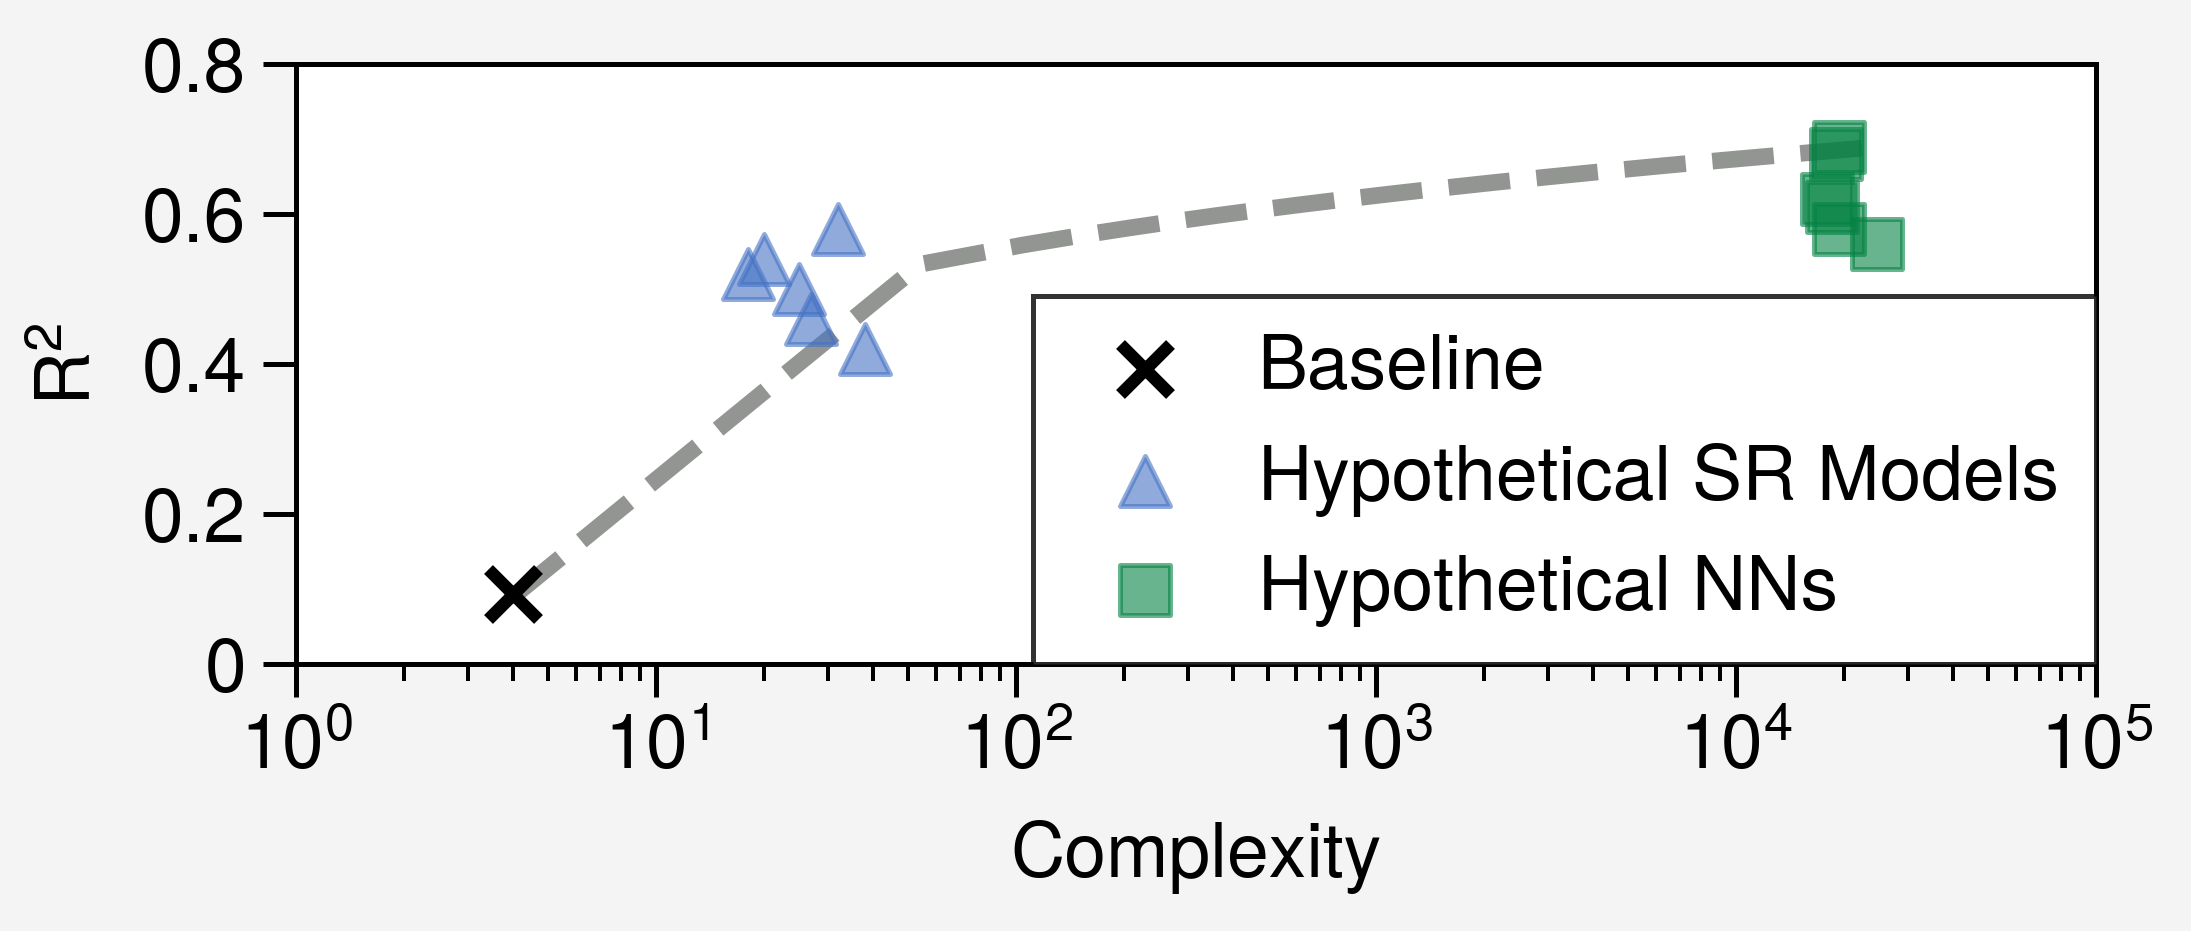

In [284]:
baseline = (4,0.093)
srmodels = np.array([
    [20,0.54],
    [18,0.52],
    [25,0.50],
    [32,0.58],
    [27,0.46],
    [38,0.42]])
nnmodels = np.array([
    [18953,0.68],
    [19303,0.69],
    [18503,0.61],
    [17934,0.62],
    [19376,0.58],
    [24589,0.56]])

xcurve = np.linspace(4,25000,500)
ycurve = 0.09+0.6*((np.log10(xcurve)-np.log10(4))/(np.log10(25000)-np.log10(4)))**0.25

fig,ax = pplt.subplots(nrows=1,ncols=1,refwidth=3,refheight=1)
ax.format(grid=False,xlabel='Complexity',xlim=(1,100000),xscale='log',xformatter='log',ylabel='R$^2$',ylim=(0,0.8),yminorticks='none')
ax.plot(xcurve,ycurve,color='gray',linewidth=2,linestyle='--',zorder=0)
ax.scatter(baseline[0],baseline[1],color='k',marker='x',label='Baseline')
ax.scatter(srmodels[:,0],srmodels[:,1],marker='^',color=BLUE,alpha=0.6,label='Hypothetical SR Models')
ax.scatter(nnmodels[:,0],nnmodels[:,1],marker='s',color=GREEN,alpha=0.6,label='Hypothetical NNs')
ax.legend(loc='lr',ncols=1)
pplt.show()

fig.patch.set_alpha(0)
for ax in fig.axes:
    ax.patch.set_alpha(1)
fig.save('fig2.png',dpi=900)

### P-$B_L$ Ramps

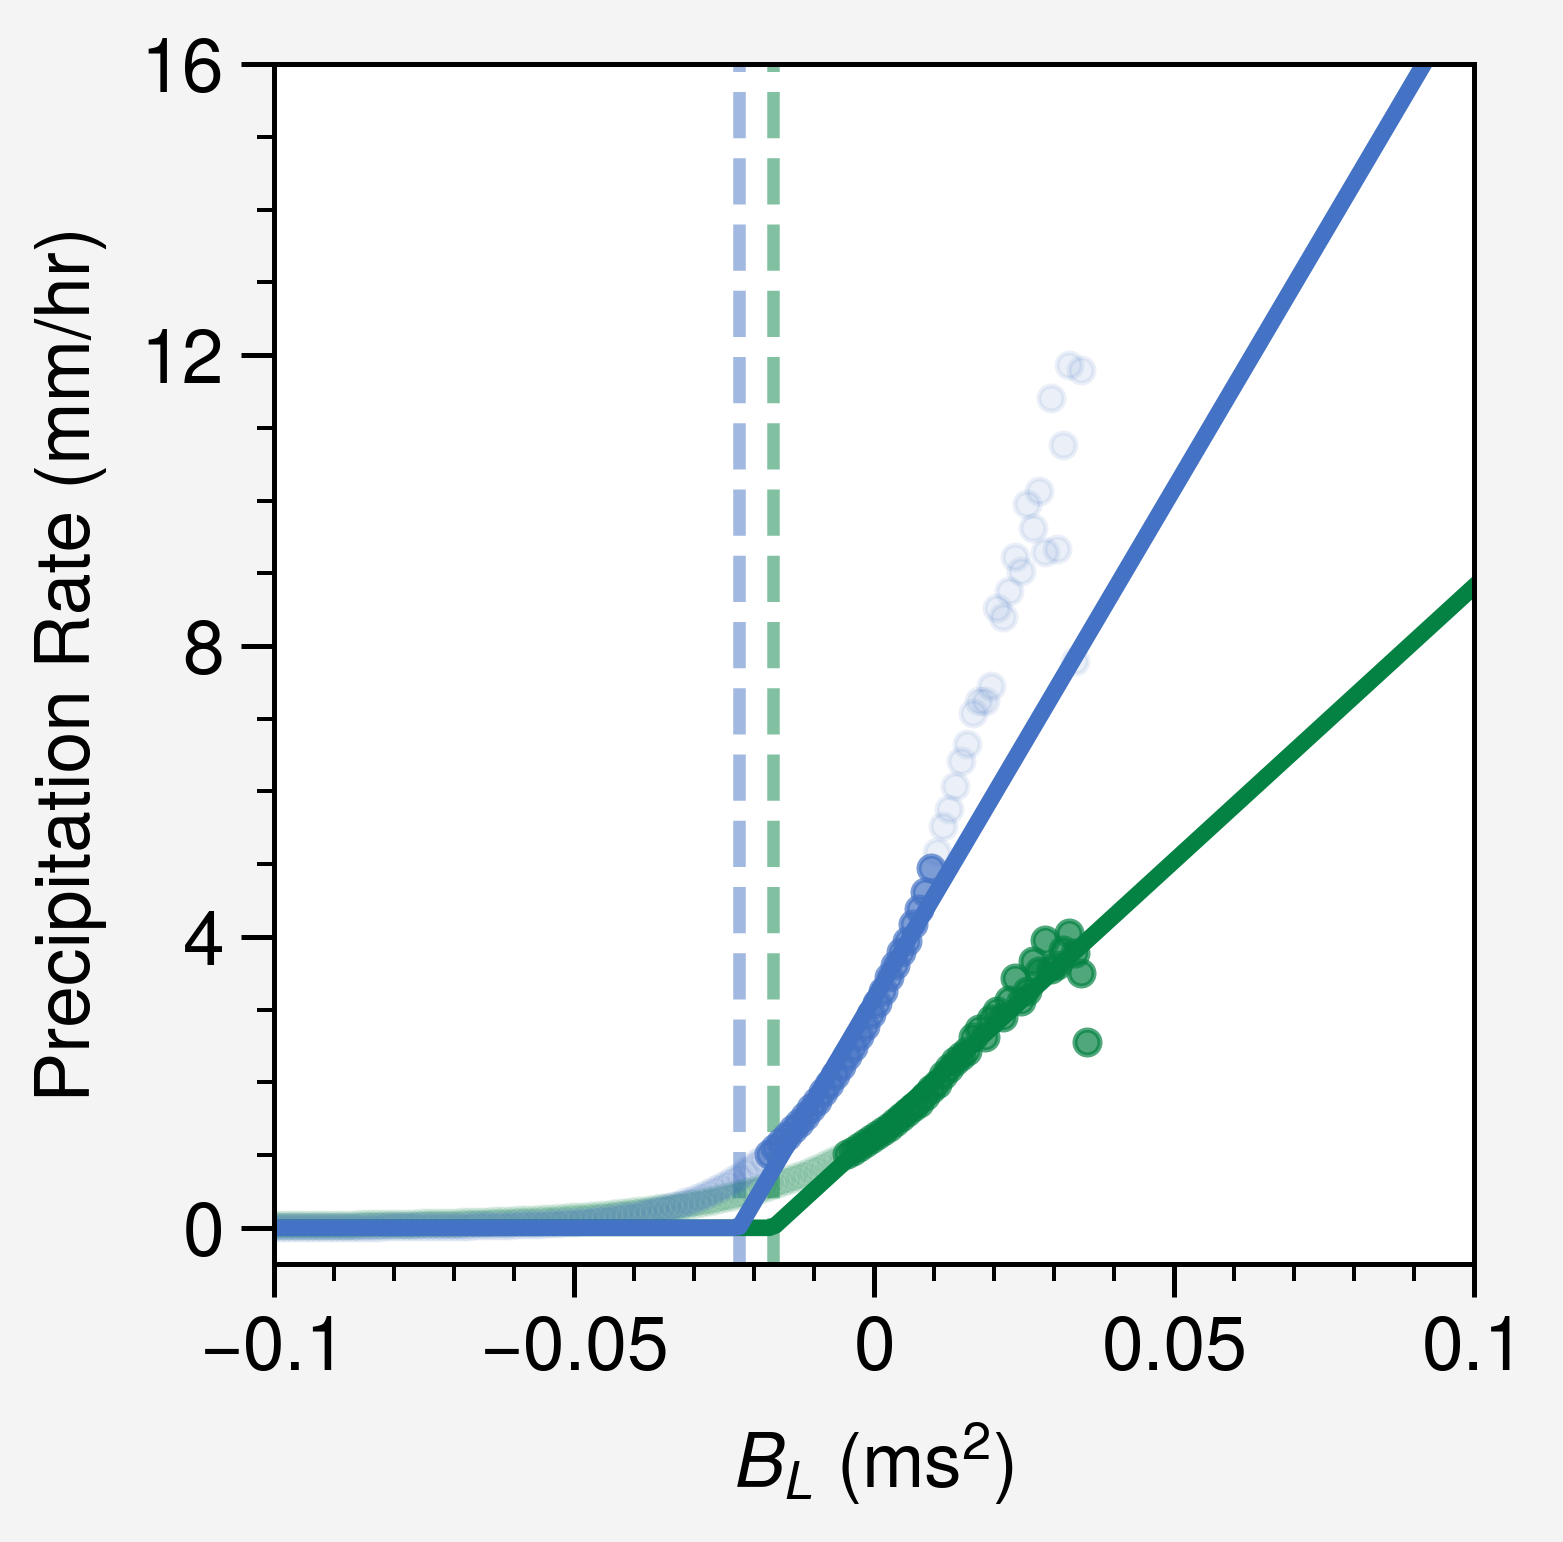

In [285]:
data          = np.load(f'{MODELDIR}/pod/pod_separate_fit.npz')
xbins         = data['bincenters']
ymeansland    = data['ymeanland']
fitrangeland  = data['fitrangeland']
alphaland     = data['alphaland']
blcritland    = data['blcritland']
ymeansocean   = data['ymeanocean']
fitrangeocean = data['fitrangeocean']
alphaocean    = data['alphaocean']
blcritocean   = data['blcritocean']

fig,ax = pplt.subplots(nrows=1,ncols=1,refwidth=2)
ax.format(grid=False,xlabel='$\mathit{B_L}$ (ms$^2$)',xlim=(-0.1,0.1),ylabel='Precipitation Rate (mm/hr)',ylim=(-0.5,16),yticks=4)
ax.scatter(xbins[~fitrangeland],ymeansland[~fitrangeland],color=GREEN,marker='.',alpha=0.1)
ax.scatter(xbins[fitrangeland],ymeansland[fitrangeland],color=GREEN,marker='.',alpha=0.7)
ax.plot(xbins,alphaland*np.maximum(0,xbins-blcritland),color=GREEN,linewidth=2,label=f'Land Ramp Fit ($\\alpha$ = {alphaland:.1f})')
ax.axvline(blcritland,color=GREEN,alpha=0.5,linestyle='--',zorder=0,label=fr'Land $\mathit{{B_c}}$ = {blcritland:.3f}')
ax.scatter(xbins[~fitrangeocean],ymeansocean[~fitrangeocean],color=BLUE,marker='.',alpha=0.1)
ax.scatter(xbins[fitrangeocean],ymeansocean[fitrangeocean],color=BLUE,marker='.',alpha=0.7)
ax.plot(xbins,alphaocean*np.maximum(0,xbins-blcritocean),color=BLUE,linewidth=2,label=f'Ocean Ramp Fit ($\\alpha$ = {alphaocean:.1f})')
ax.axvline(blcritocean,color=BLUE,alpha=0.5,linestyle='--',zorder=0,label=fr'Ocean $\mathit{{B_c}}$ = {blcritocean:.3f}')
pplt.show()

fig.patch.set_alpha(0)
for ax in fig.axes:
    ax.patch.set_alpha(1)
fig.save('fig3.png',dpi=900)

### Functions

In [286]:
def get_r2(ytrue,ypred,dims=None,landfrac=None,landthresh=LANDTHRESH):
    if dims is None:
        dims = list(ytrue.dims)
    if landfrac is not None:
        landmask  = landfrac>=LANDTHRESH
        oceanmask = landfrac<LANDTHRESH
        ytrueland = ytrue.where(landmask)
        ypredland = ypred.where(landmask)
        ssresland = ((ytrueland-ypredland)**2).sum(dim=dims,skipna=True)
        sstotland = ((ytrueland-ytrueland.mean(dim=dims,skipna=True))**2).sum(dim=dims,skipna=True)
        r2land = 1-(ssresland/sstotland)
        ytrueocean = ytrue.where(oceanmask)
        ypredocean = ypred.where(oceanmask)
        ssresocean = ((ytrueocean-ypredocean)**2).sum(dim=dims,skipna=True)
        sstotocean = ((ytrueocean-ytrueocean.mean(dim=dims,skipna=True))**2).sum(dim=dims,skipna=True)
        r2ocean = 1-(ssresocean/sstotocean)
        return float(r2land.values),float(r2ocean.values)
    ssres = ((ytrue-ypred)**2).sum(dim=dims,skipna=True)
    sstot = ((ytrue-ytrue.mean(dim=dims,skipna=True))**2).sum(dim=dims,skipna=True)
    r2 = 1-(ssres/sstot)
    return r2
    
def get_confusion_matrix(ytrue,ypred,dims=None,prthresh=PRTHRESH):
    if dims is None:
        dims = list(ytrue.dims)
    ytrueabove = ytrue>prthresh
    ypredabove = ypred>prthresh
    tp = (ypredabove&ytrueabove).sum(dim=dims,skipna=True).astype('float64')
    tn = (~ypredabove&~ytrueabove).sum(dim=dims,skipna=True).astype('float64')
    fp = (ypredabove&~ytrueabove).sum(dim=dims,skipna=True).astype('float64')
    fn = (~ypredabove&ytrueabove).sum(dim=dims,skipna=True).astype('float64')
    if dims==list(ytrue.dims):
        return int(tp),int(fp),int(fn),int(tn)
    else:
        return tp.astype('int64'),fp.astype('int64'),fn.astype('int64'),tn.astype('int64')

## Baseline Results

In [287]:
truepath = os.path.join(SPLITDIR,f'valid.h5')
with xr.open_dataset(truepath,engine='h5netcdf') as ds:
    truepr = ds['pr'].load()

predpath = os.path.join(RESULTSDIR,f'pod_separate_fit_valid_pr.nc')
with xr.open_dataset(predpath,engine='h5netcdf') as ds:
    predpr = ds['pr'].load()

ytrue,ypred = xr.align(truepr,predpr,join='inner')
ytrueflat   = ytrue.values.ravel()
ypredflat   = ypred.values.ravel()
finite      = np.isfinite(ytrueflat)&np.isfinite(ypredflat)

### Actual vs. Predicted Precipitation

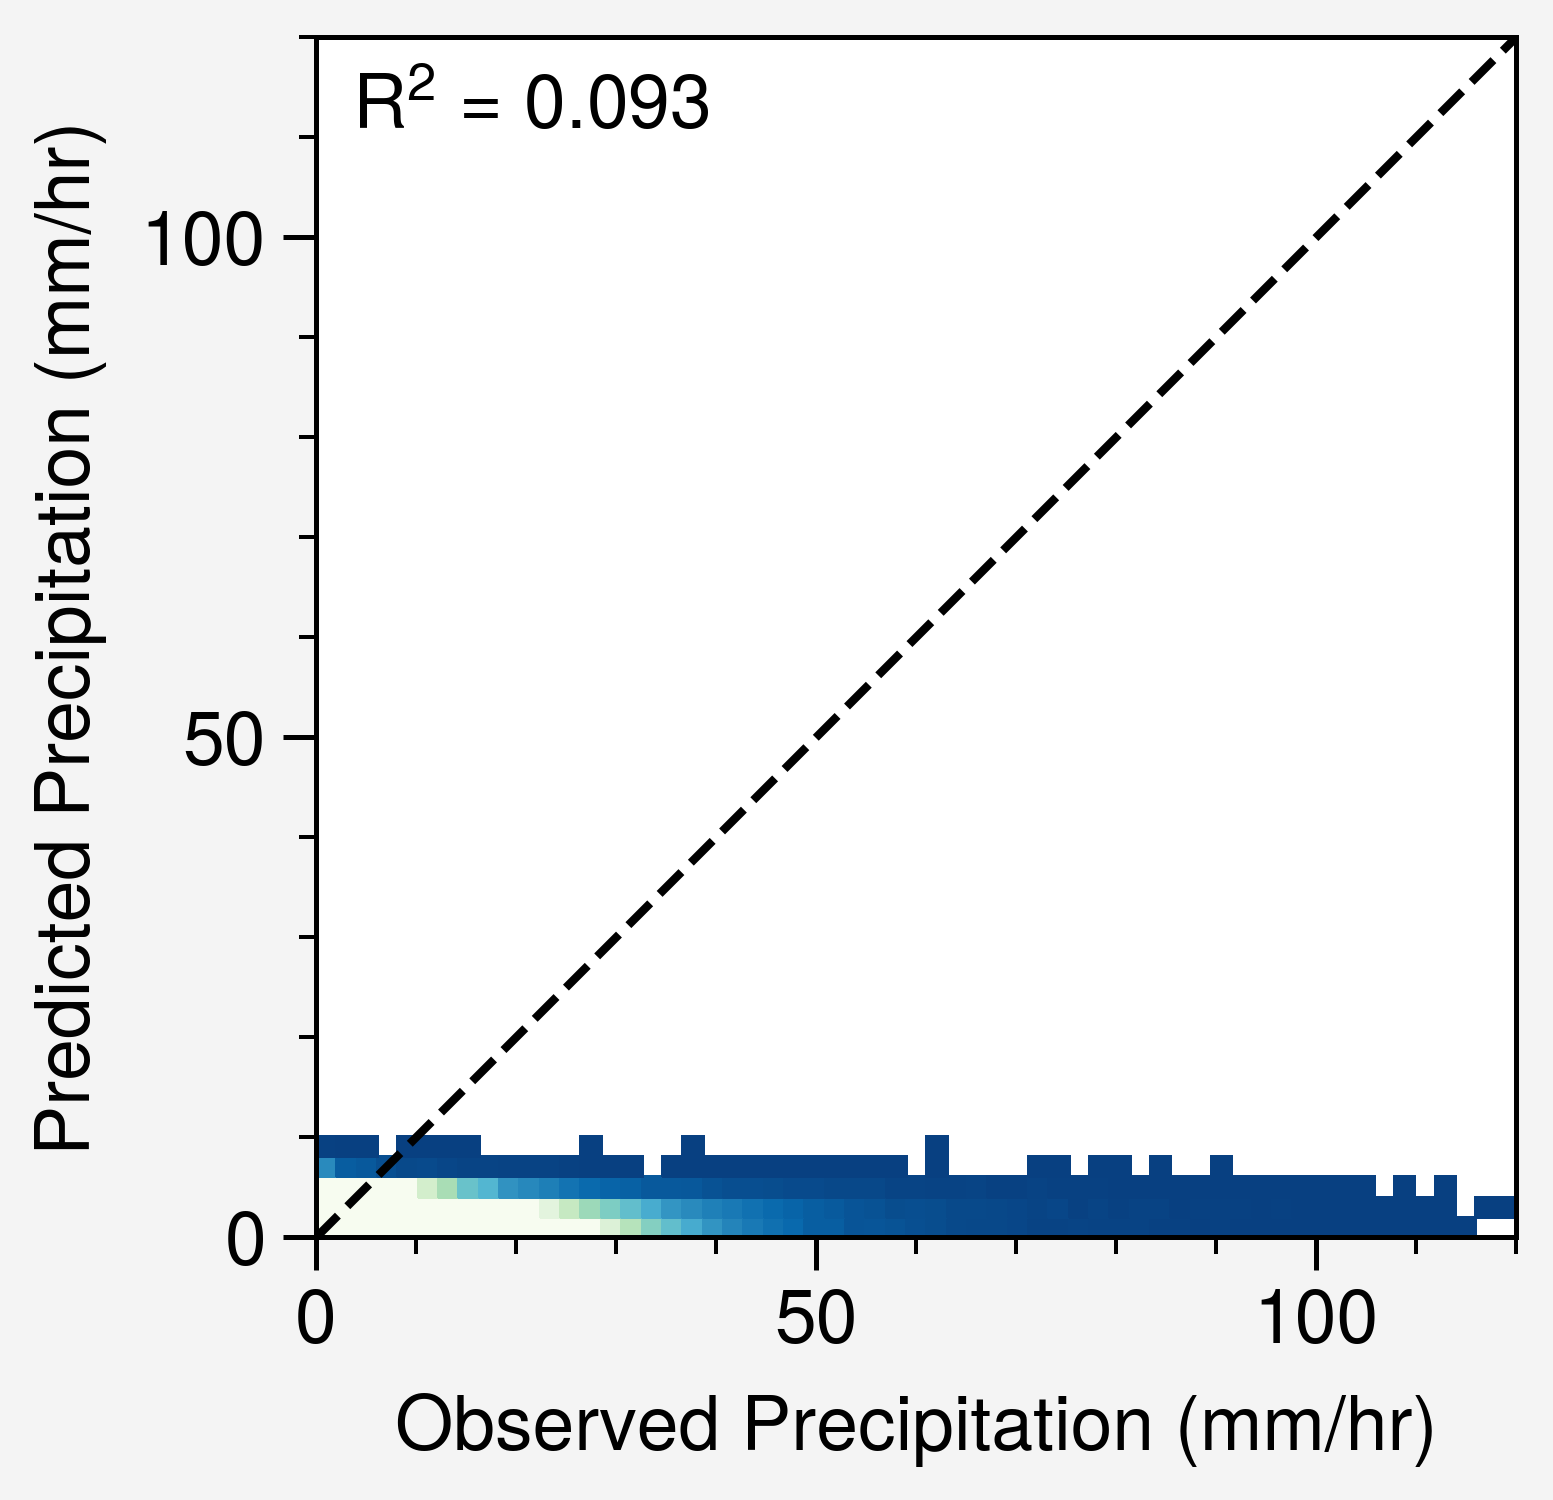

In [288]:
r2        = get_r2(ytrue,ypred,dims=None)
hist,_,_  = np.histogram2d(ytrueflat[finite],ypredflat[finite],bins=[binedges,binedges])
hist = np.ma.masked_where(hist==0,hist)

fig,ax = pplt.subplots(nrows=1,ncols=1,refwidth=2)
ax.format(xlabel='Observed Precipitation (mm/hr)',ylabel='Predicted Precipitation (mm/hr)')
im = ax.pcolormesh(binedges,binedges,hist.T,cmap='GnBu_r',vmin=0,vmax=2000,levels=200,extend='max')
ax.plot([globalmin,globalmax],[globalmin,globalmax],color='k',linewidth=1,linestyle='--')
ax.text(0.03,0.97,f'R$^2$ = {r2:.3f}',transform=ax.transAxes,va='top',ha='left')
ax.format(xlim=(globalmin,globalmax),xticks=50,ylim=(globalmin,globalmax),yticks=50)
pplt.show()

fig.patch.set_alpha(0)
for ax in fig.axes:
    ax.patch.set_alpha(1)
fig.save('fig4.png',dpi=900)

### Confusion Matrix

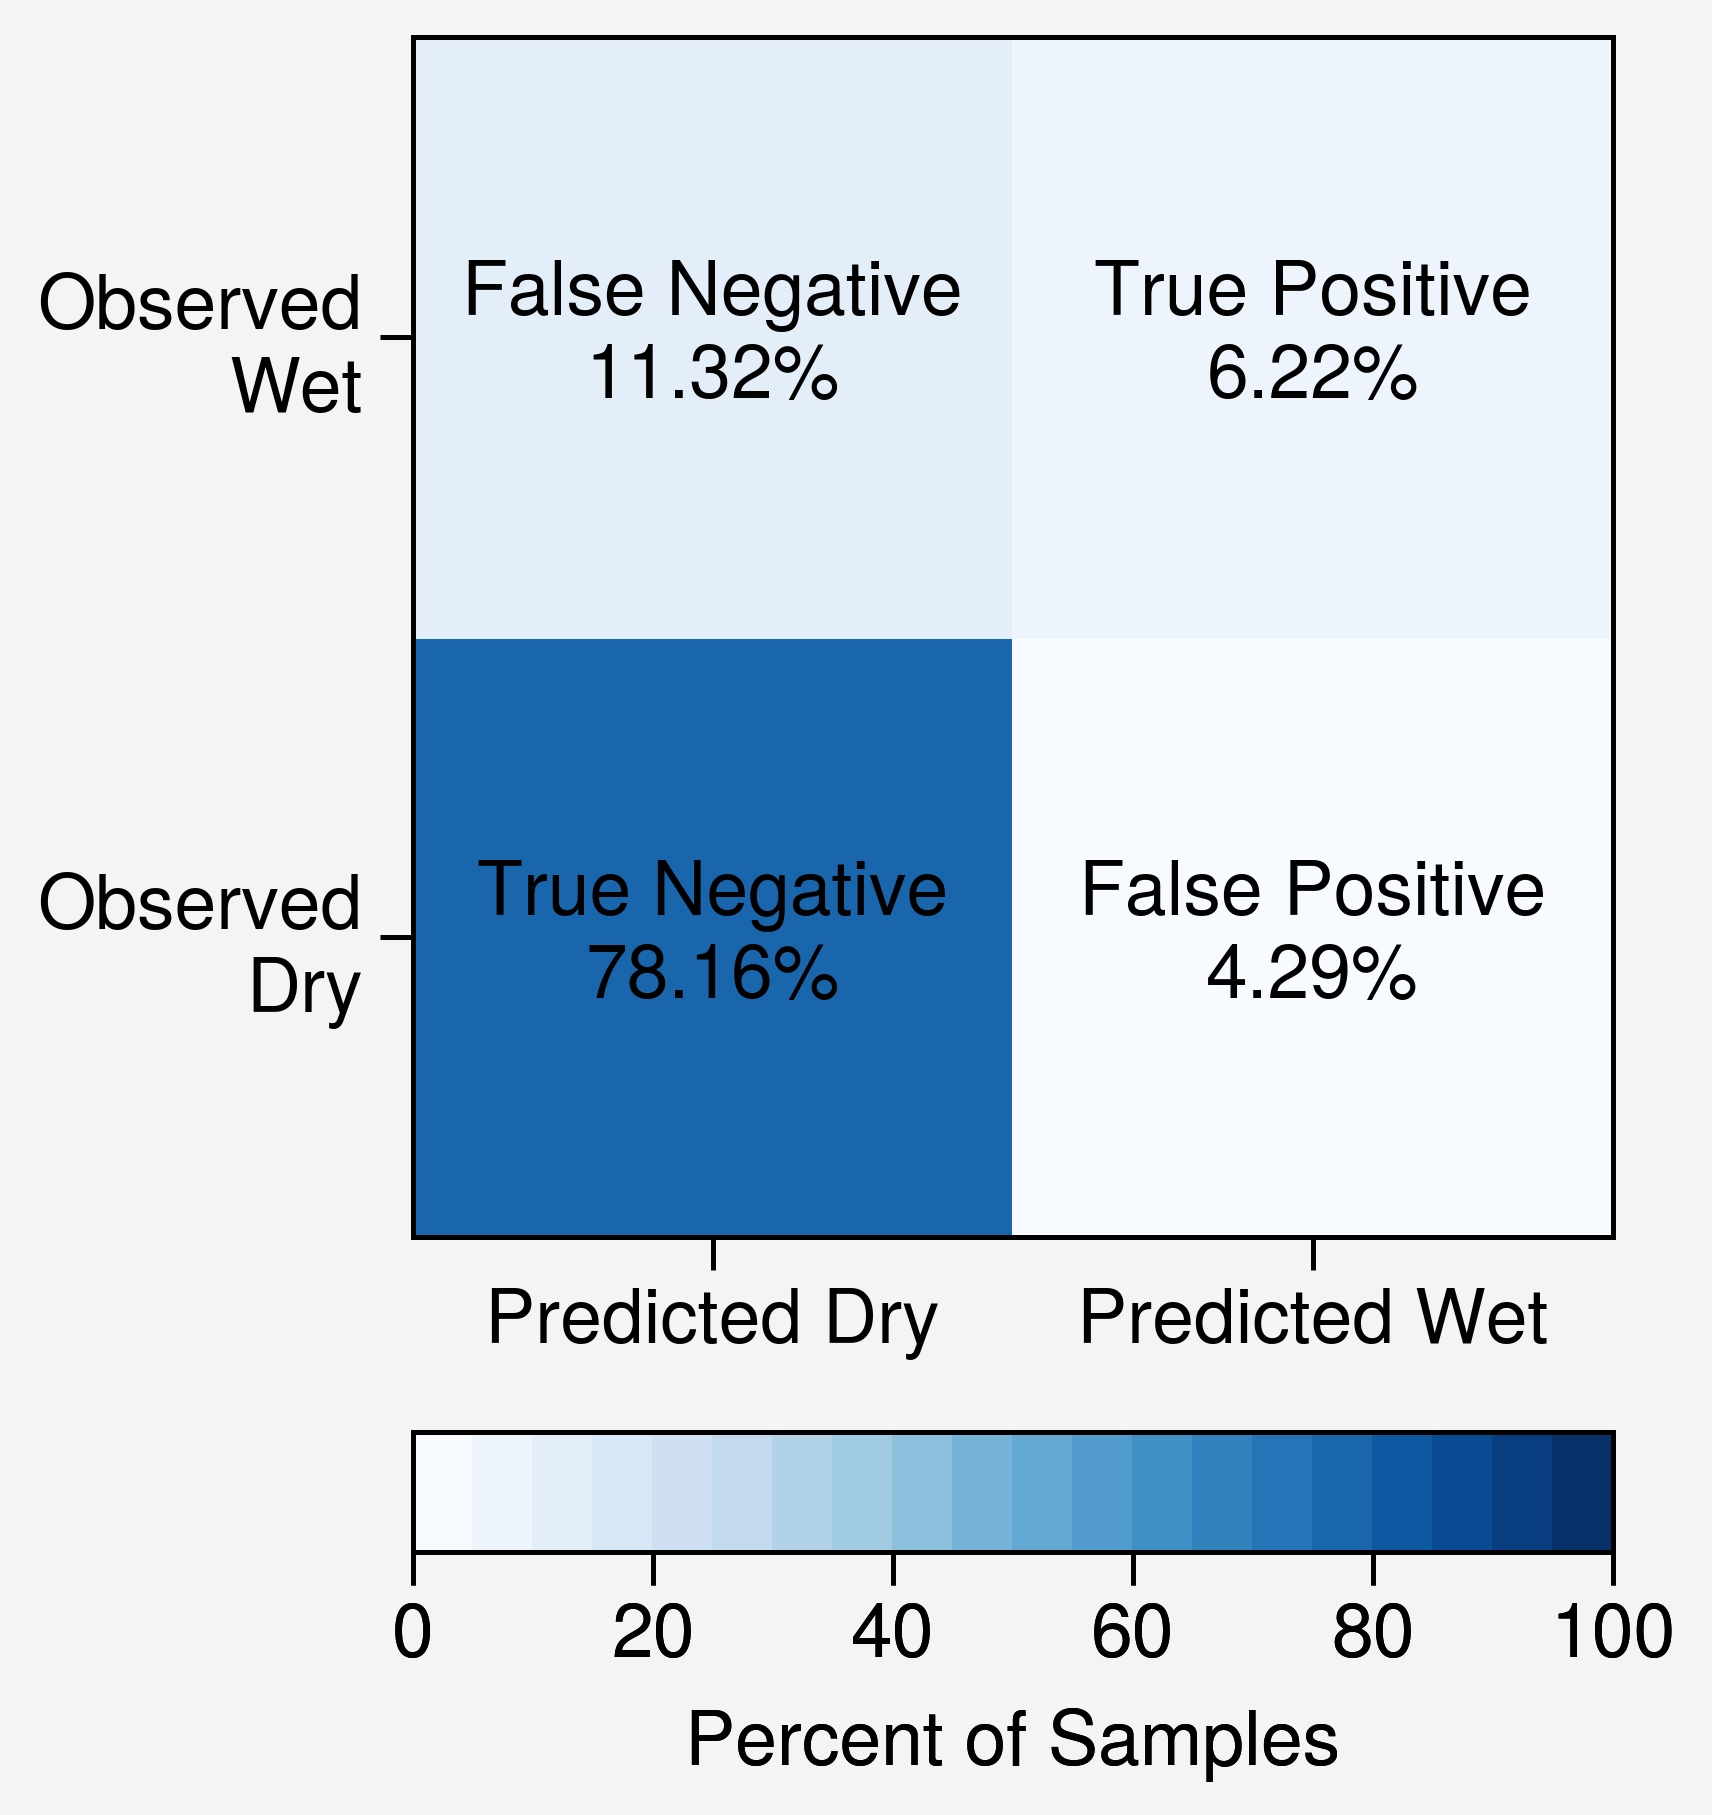

In [289]:
tp,fp,fn,tn = get_confusion_matrix(ytrue,ypred,dims=None)
total  = tp+fp+tn+fn
matrix = 100.0*np.array([[tn,fp],[fn,tp]],dtype=float)/total
edges  = [0,1,2]

fig,ax = pplt.subplots(nrows=1,ncols=1,refwidth=2)
im = ax.pcolormesh(edges,edges,matrix,cmap='Blues',vmin=0,vmax=100,levels=21)
labels = [
    ('True Negative',tn,matrix[0,0],0.5,0.5),
    ('False Positive',fp,matrix[0,1],1.5,0.5), 
    ('False Negative',fn,matrix[1,0],0.5,1.5), 
    ('True Positive',tp,matrix[1,1],1.5,1.5)]
for label,value,percent,x,y in labels:
    ax.text(x,y,f'{label}\n{percent:.2f}%',ha='center',va='center')
    ax.format(xlim=(0,2),xticks=[0.5,1.5],xticklabels=['Predicted Dry','Predicted Wet'],xminorticks='none',
              ylim=(0,2),yticks=[0.5,1.5],yticklabels=['Observed\nDry','Observed\nWet'],yminorticks='none')
fig.colorbar(im,loc='b',label='Percent of Samples')
pplt.show()

fig.patch.set_alpha(0)
for ax in fig.axes:
    ax.patch.set_alpha(1)
fig.save('fig5.png',dpi=900)

### Spatial R2

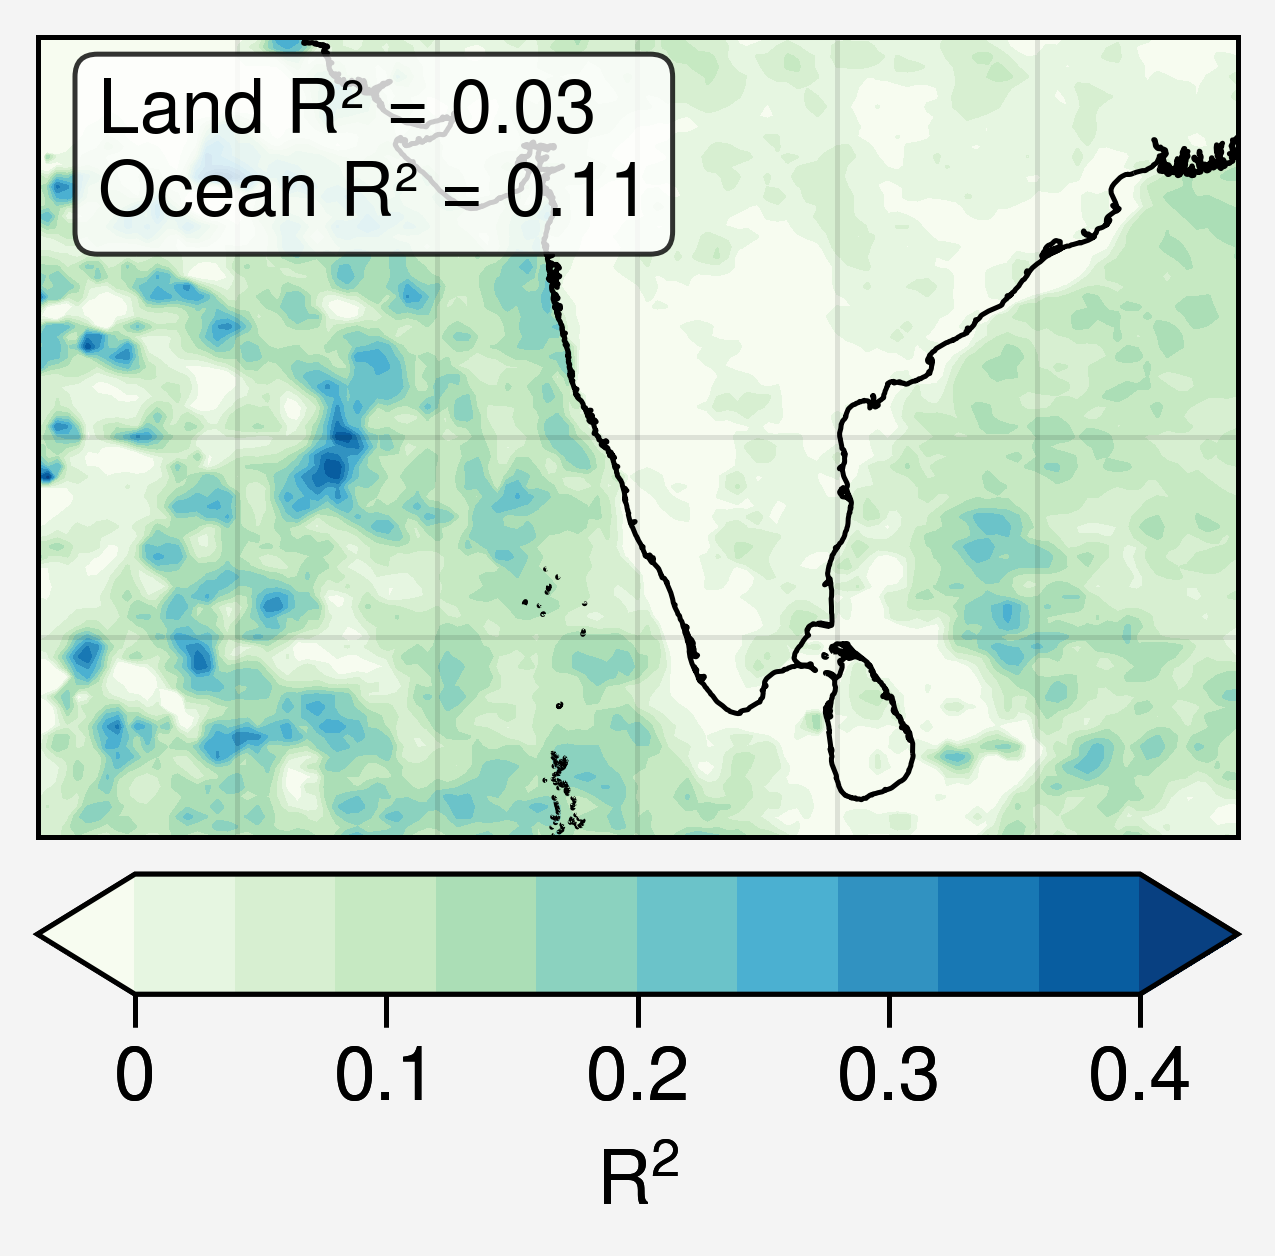

In [290]:
r2 = get_r2(ytrue,ypred,dims=['time'])
r2land,r2ocean = get_r2(ytrue,ypred,dims=['time','lat','lon'],landfrac=landfrac)

fig,ax = pplt.subplots(nrows=1,ncols=1,refwidth=2,proj='cyl')
ax.format(coast=True,latlim=(5.,25.),latlines=[5,10,15],lonlim=(60.,90.),lonlines=5)
im = ax.contourf(r2.lon,r2.lat,r2,cmap='GnBu',vmin=0,vmax=0.4,levels=10,extend='both')
ax.colorbar(im,loc='b',label='R$^2$',ticks=0.1)
ax.text(0.05,0.95,f'Land R² = {r2land:.2f}\nOcean R² = {r2ocean:.2f}',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round',facecolor='white',alpha=0.8,edgecolor='k'))
pplt.show()

fig.patch.set_alpha(0)
for ax in fig.axes:
    ax.patch.set_alpha(1)
fig.save('fig6.png',dpi=900)

## NN Results

In [291]:
truepath = os.path.join(SPLITDIR,f'valid.h5')
with xr.open_dataset(truepath,engine='h5netcdf') as ds:
    truepr = ds['pr'].load()

predpath = os.path.join(RESULTSDIR,f'nn_bl_only_lf_mse_norm_valid_pr.nc')
with xr.open_dataset(predpath,engine='h5netcdf') as ds:
    predpr = ds['predpr'].load()

ytrue,ypred = xr.align(truepr,predpr,join='inner')
ytrueflat   = ytrue.values.ravel()
ypredflat   = ypred.values.ravel()
finite      = np.isfinite(ytrueflat)&np.isfinite(ypredflat)

### Actual vs. Predicted Precipitation

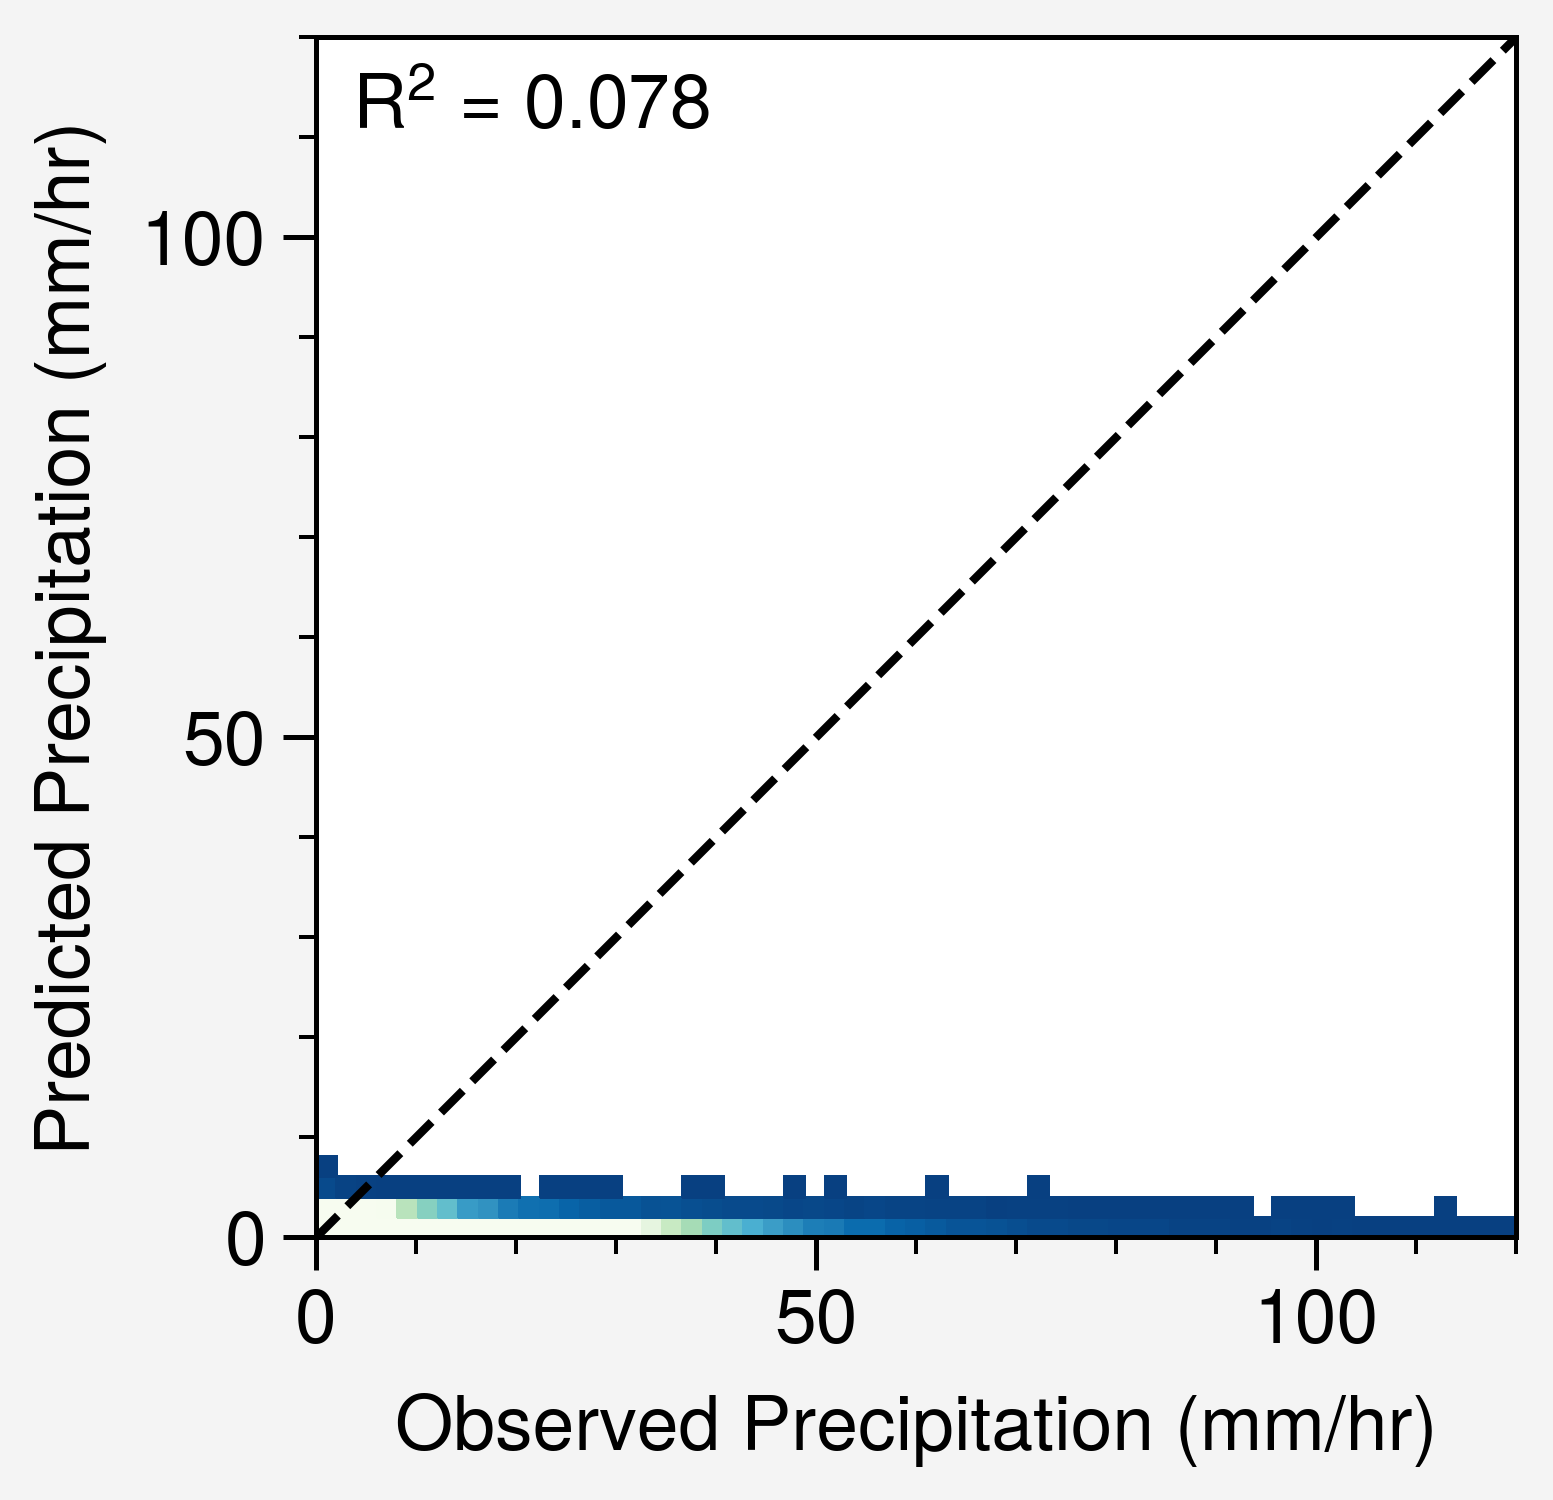

In [292]:
r2        = get_r2(ytrue,ypred,dims=None)
hist,_,_  = np.histogram2d(ytrueflat[finite],ypredflat[finite],bins=[binedges,binedges])
hist = np.ma.masked_where(hist==0,hist)

fig,ax = pplt.subplots(nrows=1,ncols=1,refwidth=2)
ax.format(xlabel='Observed Precipitation (mm/hr)',ylabel='Predicted Precipitation (mm/hr)')
im = ax.pcolormesh(binedges,binedges,hist.T,cmap='GnBu_r',vmin=0,vmax=2000,levels=200,extend='max')
ax.plot([globalmin,globalmax],[globalmin,globalmax],color='k',linewidth=1,linestyle='--')
ax.text(0.03,0.97,f'R$^2$ = {r2:.3f}',transform=ax.transAxes,va='top',ha='left')
ax.format(xlim=(globalmin,globalmax),xticks=50,ylim=(globalmin,globalmax),yticks=50)
pplt.show()

fig.patch.set_alpha(0)
for ax in fig.axes:
    ax.patch.set_alpha(1)
fig.save('fig7.png',dpi=900)

### Confusion Matrix

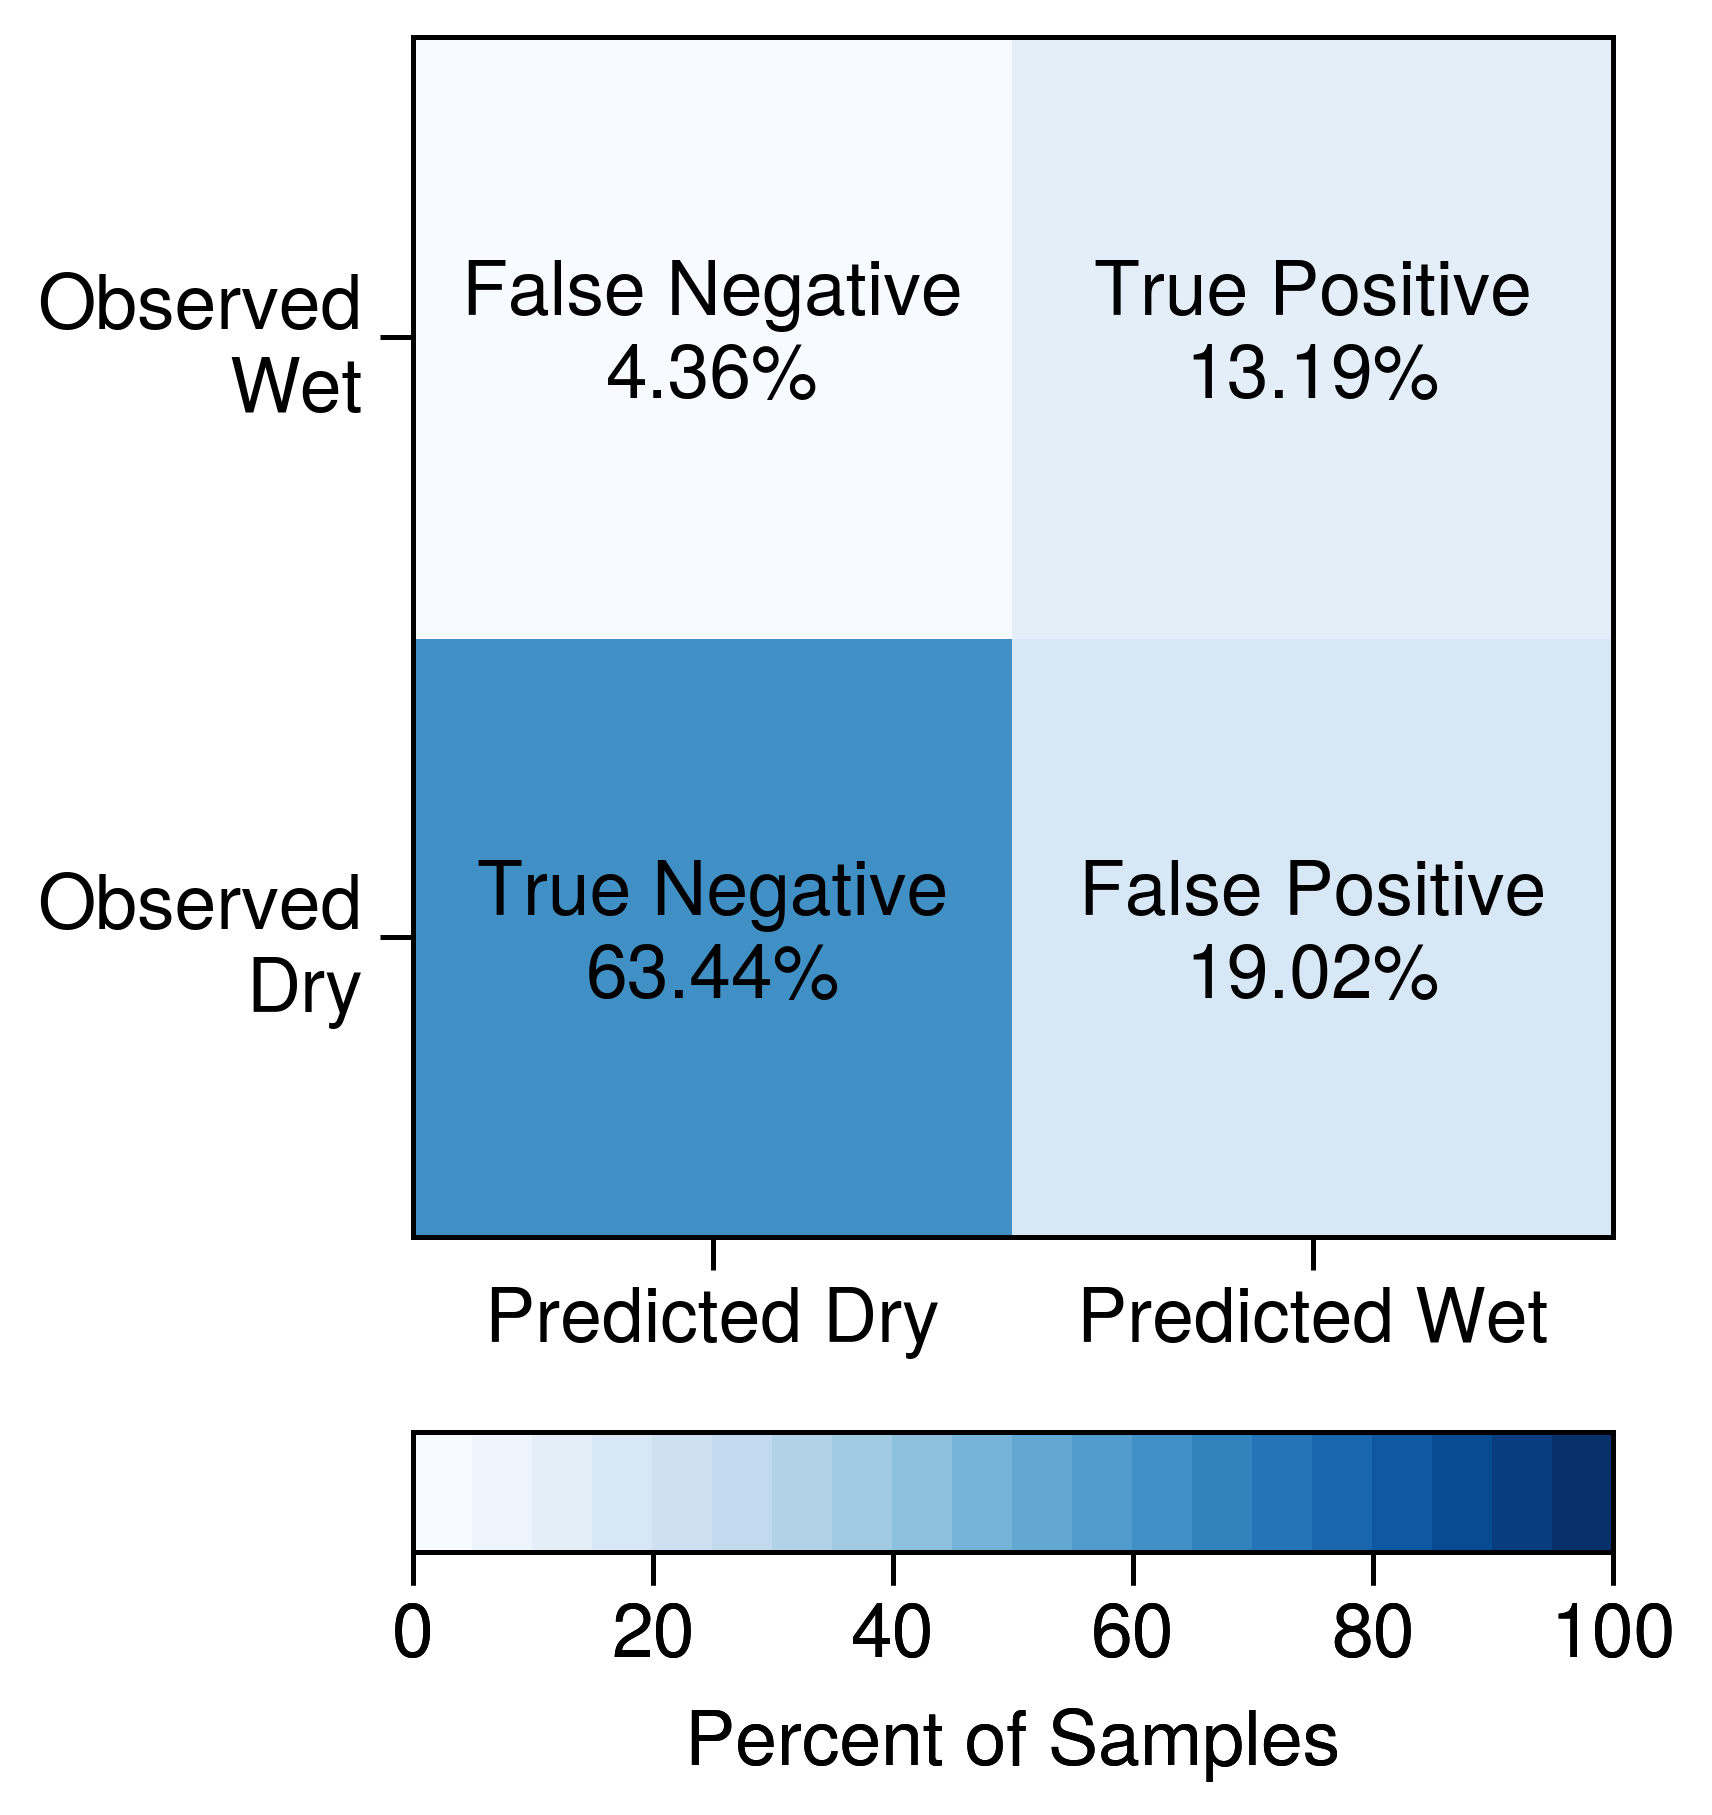

In [293]:
tp,fp,fn,tn = get_confusion_matrix(ytrue,ypred,dims=None)
total  = tp+fp+tn+fn
matrix = 100.0*np.array([[tn,fp],[fn,tp]],dtype=float)/total
edges  = [0,1,2]

fig,ax = pplt.subplots(nrows=1,ncols=1,refwidth=2)
im = ax.pcolormesh(edges,edges,matrix,cmap='Blues',vmin=0,vmax=100,levels=21)
labels = [
    ('True Negative',tn,matrix[0,0],0.5,0.5),
    ('False Positive',fp,matrix[0,1],1.5,0.5), 
    ('False Negative',fn,matrix[1,0],0.5,1.5), 
    ('True Positive',tp,matrix[1,1],1.5,1.5)]
for label,value,percent,x,y in labels:
    ax.text(x,y,f'{label}\n{percent:.2f}%',ha='center',va='center')
    ax.format(xlim=(0,2),xticks=[0.5,1.5],xticklabels=['Predicted Dry','Predicted Wet'],xminorticks='none',
              ylim=(0,2),yticks=[0.5,1.5],yticklabels=['Observed\nDry','Observed\nWet'],yminorticks='none')
fig.colorbar(im,loc='b',label='Percent of Samples')

fig.patch.set_alpha(0)
for ax in fig.axes:
    ax.patch.set_alpha(1)
fig.save('fig8.png',dpi=900)

### Spatial R2

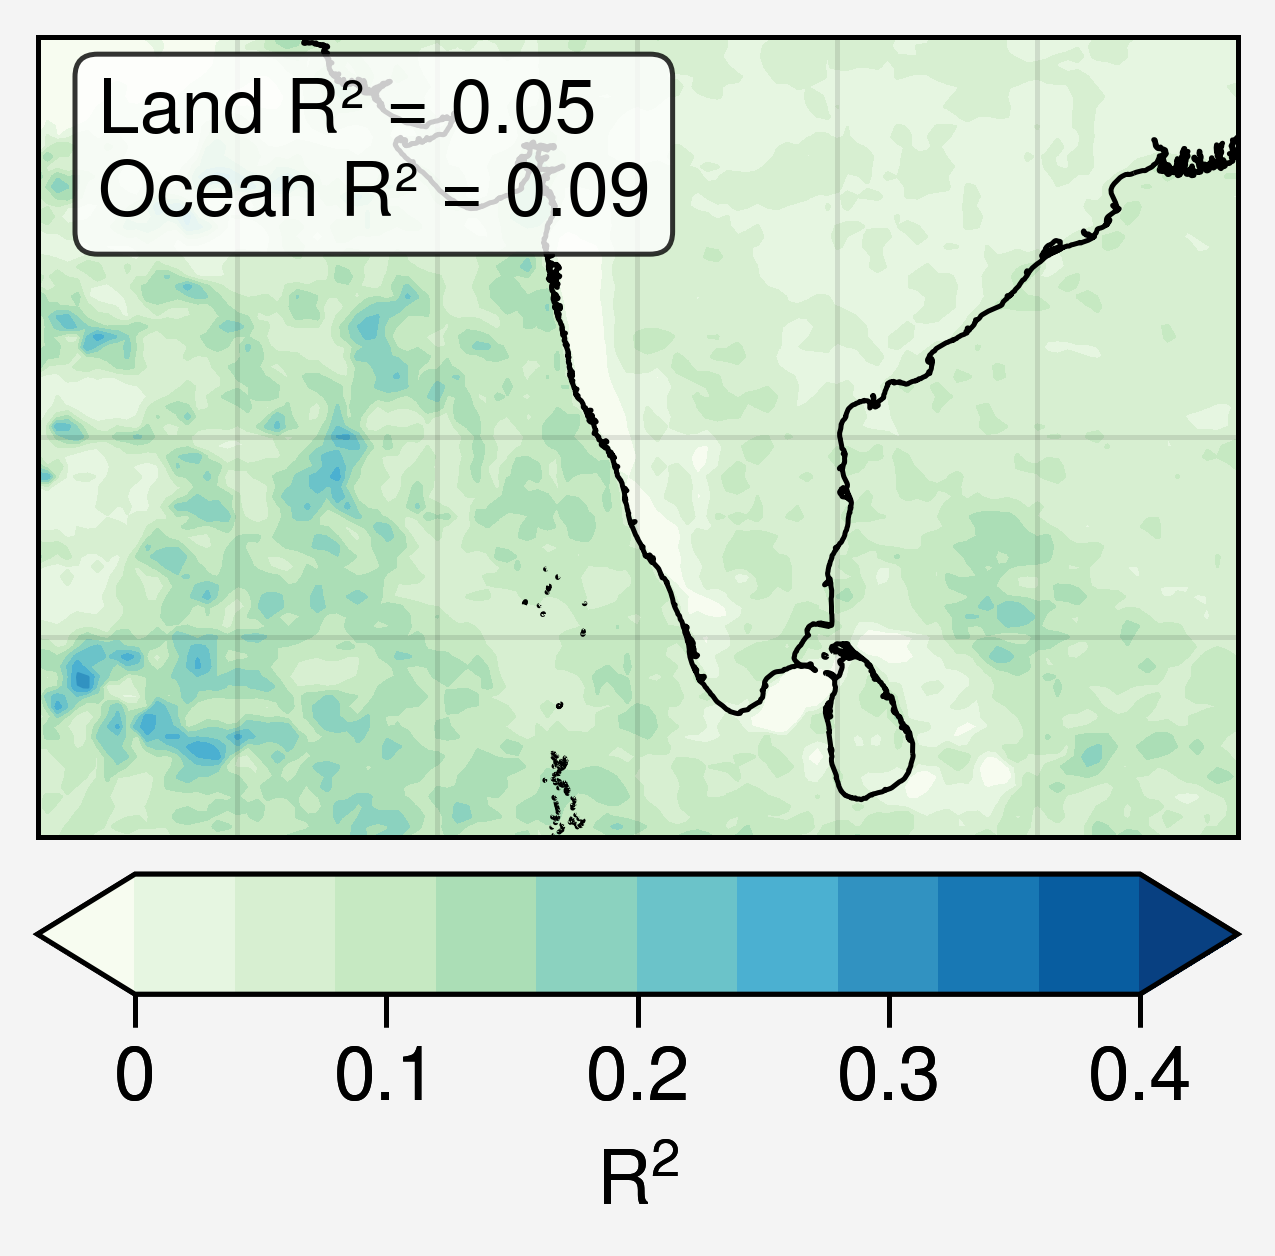

In [294]:
r2 = get_r2(ytrue,ypred,dims=['time'])
r2land,r2ocean = get_r2(ytrue,ypred,dims=['time','lat','lon'],landfrac=landfrac)

fig,ax = pplt.subplots(nrows=1,ncols=1,refwidth=2,proj='cyl')
ax.format(coast=True,latlim=(5.,25.),latlines=[5,10,15],lonlim=(60.,90.),lonlines=5)
im = ax.contourf(r2.lon,r2.lat,r2,cmap='GnBu',vmin=0,vmax=0.4,levels=10,extend='both')
ax.colorbar(im,loc='b',label='R$^2$',ticks=0.1)
ax.text(0.05,0.95,f'Land R² = {r2land:.2f}\nOcean R² = {r2ocean:.2f}',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round',facecolor='white',alpha=0.8,edgecolor='k'))
pplt.show()

fig.patch.set_alpha(0)
for ax in fig.axes:
    ax.patch.set_alpha(1)
fig.save('fig9.png',dpi=900)

## NN Architecture

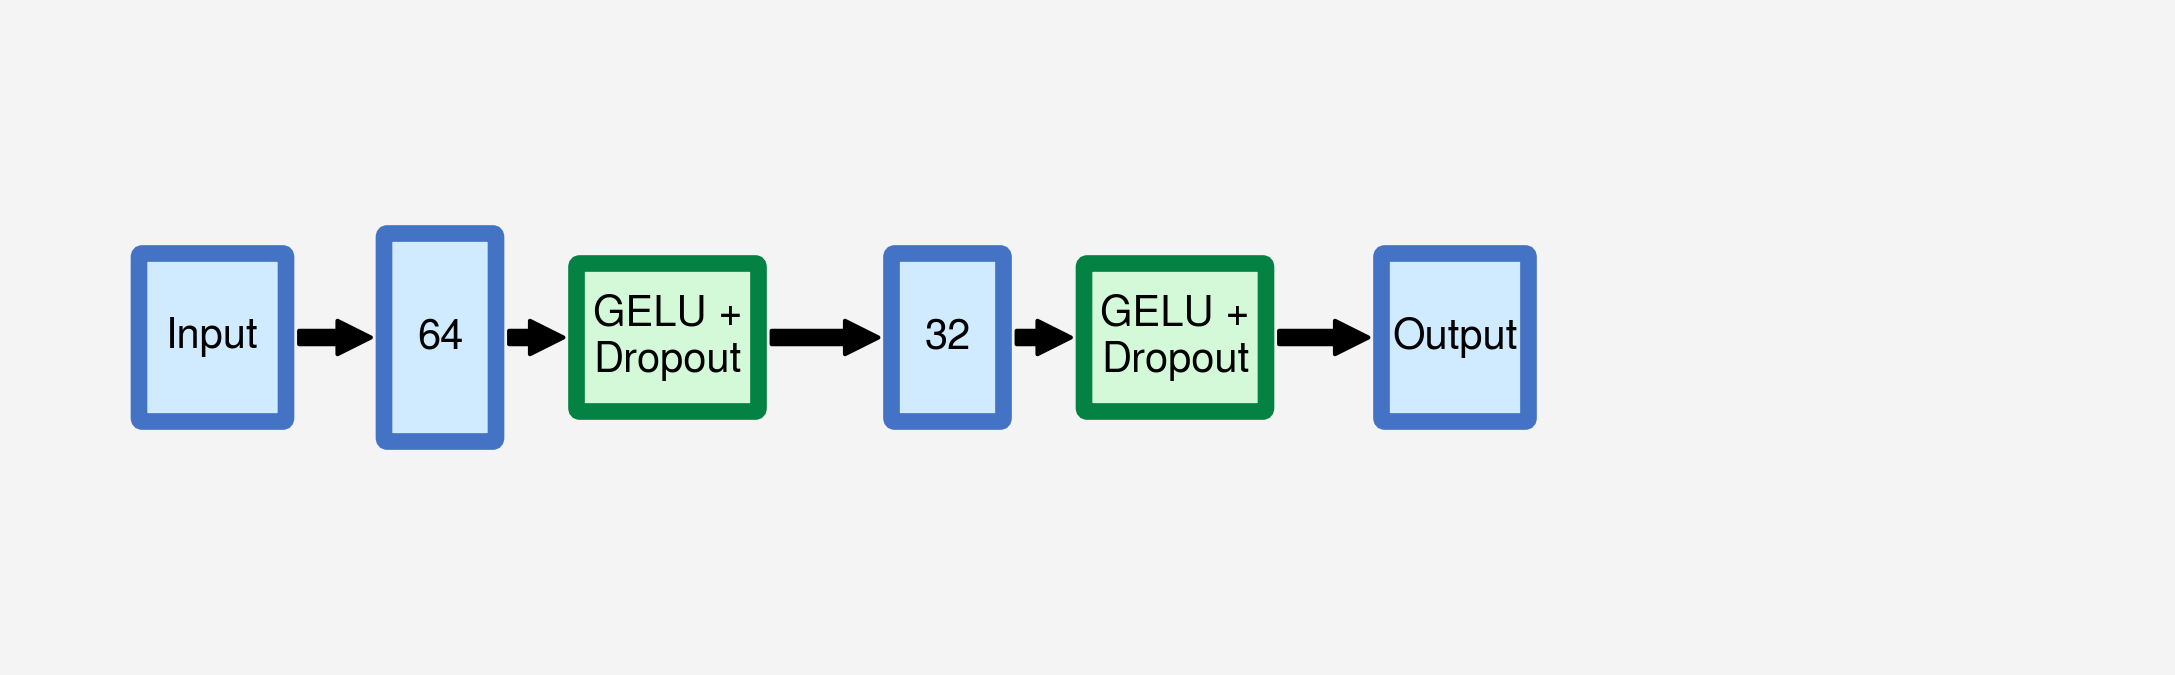

In [295]:
layers = [
    (1,1.5,'Input',0.8,0.8),
    (2.3,1.5,'64',0.6,1.0),
    (3.6,1.5,'GELU +\nDropout',1.0,0.7),
    (5.2,1.5,'32',0.6,0.8),
    (6.5,1.5,'GELU +\nDropout',1.0,0.7),
    (8.1,1.5,'Output',0.8,0.8)]


fig,ax = pplt.subplots(nrows=1,ncols=1,refwidth=3.5,refheight=1)
ax.format(xlim=(0,12),ylim=(0,3))
ax.axis('off')
for x,y,label,w,h in layers:
    if 'GELU' in label:
        edgecolor,facecolor = GREEN,'green1'
    else:
        edgecolor,facecolor = BLUE,'blue1'
    box = FancyBboxPatch((x-w/2,y-h/2),w,h,boxstyle='round,pad=0.02',edgecolor=edgecolor,facecolor=facecolor,linewidth=2)
    ax.add_patch(box)
    ax.text(x,y,label,ha='center',va='center',fontsize=5)
for i in range(len(layers)-1):
    x1,y1 = layers[i][0],layers[i][1]
    x2,y2 = layers[i+1][0],layers[i+1][1]
    w1,w2 = layers[i][3],layers[i+1][3]
    arrow = FancyArrowPatch((x1+w1/2,y1),(x2-w2/2,y2),arrowstyle='simple',mutation_scale=8,color='k',linewidth=0.5)
    ax.add_patch(arrow)
plt.tight_layout()
plt.show()

fig.patch.set_alpha(0)
for ax in fig.axes:
    ax.patch.set_alpha(1)
fig.save('fig10.png',dpi=900)

## Training and Validation Losses

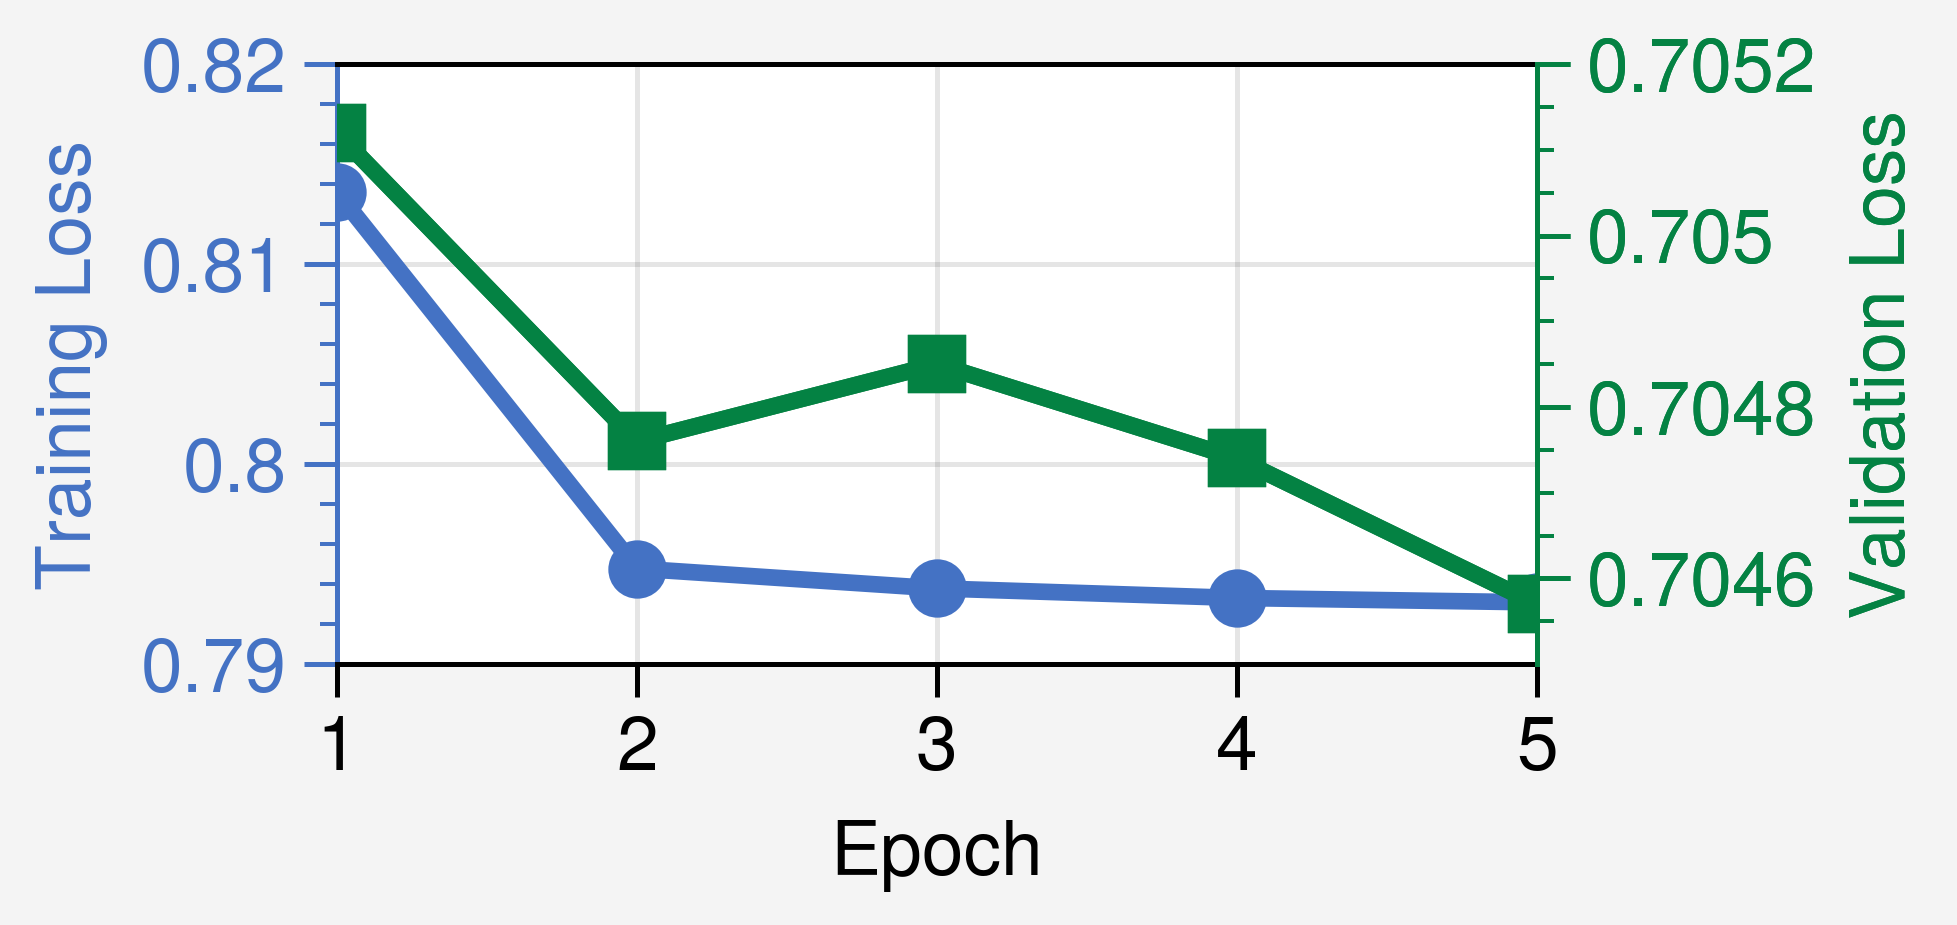

In [296]:
epochs      = [1,2,3,4,5]
trainlosses = [0.81361,0.79478,0.79379,0.79331,0.79309]
validlosses = [0.70512,0.70476,0.70485,0.70474,0.70457]

fig,ax = pplt.subplots(nrows=1,ncols=1,refwidth=2,refheight=1)
bx = ax.twinx()
ax.plot(epochs,trainlosses,color=BLUE,marker='o',linewidth=2,markersize=6)
bx.plot(epochs,validlosses,color=GREEN,marker='s',linewidth=2,markersize=6)
ax.format(xlabel='Epoch',ylabel='Training Loss',xticks=epochs,xminorticks='none',ylim=(0.79,0.82),ycolor=BLUE)
bx.format(ylabel='Validation Loss',ylim=(0.7045,0.7052),ycolor=GREEN)
pplt.show()

fig.patch.set_alpha(0)
for ax in fig.axes:
    ax.patch.set_alpha(1)
fig.save('fig11.png',dpi=900)